In [1]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

2023-03-29 22:21:12.225062: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-29 22:21:15.101779: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-29 22:21:15.113332: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 22:21:21.809829: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


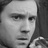

In [2]:
# loading a sample image
sample_image = Image.open("/workspaces/awesome-ml-group/00_source_data/images/train/angry/0.jpg")
sample_image

In [3]:
np.array(sample_image).shape

(48, 48)

In [4]:
def load_and_crop(image_path, crop_size, normalized=True):
    image = Image.open(image_path).resize([200,200])
    width, height = image.size   # Get dimensions
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2
    # Crop the center of the image
    image = ImageOps.grayscale(image.crop((left, top, right, bottom)))
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

(23056, 48, 48, 1) (23056, 7)
(5765, 48, 48, 1) (5765, 7)


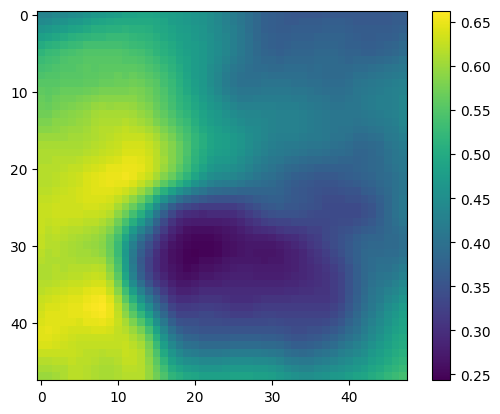

In [5]:
# code to load all the data, assuming dataset is at PBC_dataset_normal_DIB relative path
emo_types = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []
for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/workspaces/awesome-ml-group/00_source_data/images/train', emo_types[emo_ind],'*.jpg'))
    x_data += [load_and_crop(image_path, 48) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 48, 48, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

In [6]:
x_train[0].shape

(48, 48, 1)

In [7]:
VGG16_model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(x_train[0].shape),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # dense layer:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4096, activation='relu'),
    tf.keras.layers.Dense(units=4096, activation='relu'),
    tf.keras.layers.Dense(units=1000, activation='relu'),

    # output layer:
    tf.keras.layers.Dense(units=7, activation='softmax')
])

2023-03-29 22:22:27.839885: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2023-03-29 22:22:27.893830: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2023-03-29 22:22:27.915002: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2023-03-29 22:22:27.956687: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2023-03-29 22:22:28.049621: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.


In [8]:
VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                    

In [9]:
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                     loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                     metrics=tf.keras.metrics.SparseCategoricalAccuracy())  # pick a metric to monitor

In [10]:
hist = VGG16_model.fit(x_train, y_train,
              epochs=10,
              batch_size=32,
              validation_data=(x_val, y_val))

Epoch 1/10


: 

: 

In [ ]:
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(np.arange(15),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(15),hist.history.get('val_accuracy'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.title("Training & Validation Accuracy, learning rate = 0.0001")

plt.subplot(1, 2, 2) # index 2
plt.plot(np.arange(15),hist.history.get('loss'), label="Train")
plt.plot(np.arange(15),hist.history.get('val_loss'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title("Training & Validation Loss, learning rate = 0.0001")
plt.show()